In [5]:
pip install scikit-learn pandas numpy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -----------------

In [6]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Metrics
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [12]:
DATA_PATH = r"C:\Users\maitr\Documents\finstreet\SONATA.csv"
df = pd.read_csv(DATA_PATH)

# 🔹 Normalize column names
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
)

# 🔹 Rename datetime → date (CRITICAL)
if "datetime" in df.columns:
    df.rename(columns={"datetime": "date"}, inplace=True)

# 🔹 Required columns (as per problem statement)
required_cols = ["date", "open", "high", "low", "close", "volume"]

missing = [col for col in required_cols if col not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# 🔹 Convert to datetime
df["date"] = pd.to_datetime(df["date"])

# 🔹 Sort chronologically
df = df.sort_values("date").reset_index(drop=True)

# 🔹 Keep ONLY allowed columns (rule compliance)
df = df[required_cols]

df.tail()




,date,open,high,low,close,volume
275,2025-12-30 11:15:00+05:30,355.750000,358.399994,355.549988,358.299988,42258
276,2025-12-30 12:15:00+05:30,358.250000,360.399994,357.700012,360.200012,43483
277,2025-12-30 13:15:00+05:30,360.200012,361.799988,359.700012,361.450012,43174
278,2025-12-30 14:15:00+05:30,361.149994,363.500000,355.399994,356.000000,351516
279,2025-12-30 15:15:00+05:30,356.149994,360.149994,355.750000,357.950012,166653


In [14]:
df = df[
    (df["date"] >= "2025-11-01") &
    (df["date"] <= "2025-12-31")
].reset_index(drop=True)

df.shape



(280, 6)

In [20]:
def feature_engineering(df):
    df = df.copy()

    df["ret_1"] = df["close"].pct_change()

    df["sma_5"] = df["close"].rolling(5).mean()
    df["sma_10"] = df["close"].rolling(10).mean()

    df["vol_5"] = df["ret_1"].rolling(5).std()

    delta = df["close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(14).mean() / loss.rolling(14).mean()
    df["rsi_14"] = 100 - (100 / (1 + rs))

    return df

df = feature_engineering(df)
df.dropna(inplace=True)

df.tail()


,date,open,high,low,close,volume,future_5d_return,target,ret_1,sma_5,sma_10,vol_5,rsi_14
270,2025-12-29 13:15:00+05:30,357.600006,357.850006,353.850006,353.899994,98254,0.012433,1,-0.010347,357.740002,363.100000,0.006396,47.352912
271,2025-12-29 14:15:00+05:30,354.000000,358.350006,353.299988,357.600006,170875,0.007271,1,0.010455,356.990002,361.860001,0.008522,49.435037
272,2025-12-29 15:15:00+05:30,357.500000,358.000000,356.000000,356.899994,49310,0.012749,1,-0.001958,356.800000,360.525000,0.007422,46.704844
273,2025-12-30 09:15:00+05:30,355.250000,355.250000,352.500000,353.250000,0,0.007785,1,-0.010227,355.850000,358.975000,0.008533,29.140114
274,2025-12-30 10:15:00+05:30,353.250000,357.799988,353.250000,355.750000,32398,0.006184,1,0.007077,355.479999,357.885001,0.009616,35.846135


In [21]:
df["future_5d_return"] = df["close"].shift(-5) / df["close"] - 1
df["target"] = (df["future_5d_return"] > 0).astype(int)

df.dropna(inplace=True)

df[["date", "future_5d_return", "target"]].tail()


,date,future_5d_return,target
265,2025-12-26 15:15:00+05:30,-0.034774,0
266,2025-12-29 09:15:00+05:30,-0.010378,0
267,2025-12-29 10:15:00+05:30,-0.002655,0
268,2025-12-29 11:15:00+05:30,-0.013268,0
269,2025-12-29 12:15:00+05:30,-0.005173,0


In [22]:
features = ["ret_1", "sma_5", "sma_10", "vol_5", "rsi_14"]

missing = [f for f in features if f not in df.columns]
if missing:
    raise RuntimeError(f"Feature engineering failed: {missing}")

print("All features present ✅")


All features present ✅


In [23]:
split_date = df["date"].quantile(0.7)

train_df = df[df["date"] <= split_date].copy()
test_df  = df[df["date"] > split_date].copy()

X_train = train_df[features]
y_train = train_df["target"]

X_test = test_df[features]
y_test = test_df["target"]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [24]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=RANDOM_STATE
)

model.fit(X_train, y_train)

preds = model.predict(X_test)
print("Directional Accuracy:", accuracy_score(y_test, preds))


Directional Accuracy: 0.5064935064935064


In [25]:
test_df["signal"] = preds
test_df["position"] = test_df["signal"].shift(1).fillna(0)


In [26]:
STOP_LOSS = -0.02
TAKE_PROFIT = 0.04

test_df["ret_1"] = test_df["close"].pct_change()
test_df["strategy_return"] = test_df["position"] * test_df["ret_1"]

test_df["strategy_return"] = test_df["strategy_return"].clip(
    lower=STOP_LOSS,
    upper=TAKE_PROFIT
)

test_df.dropna(inplace=True)


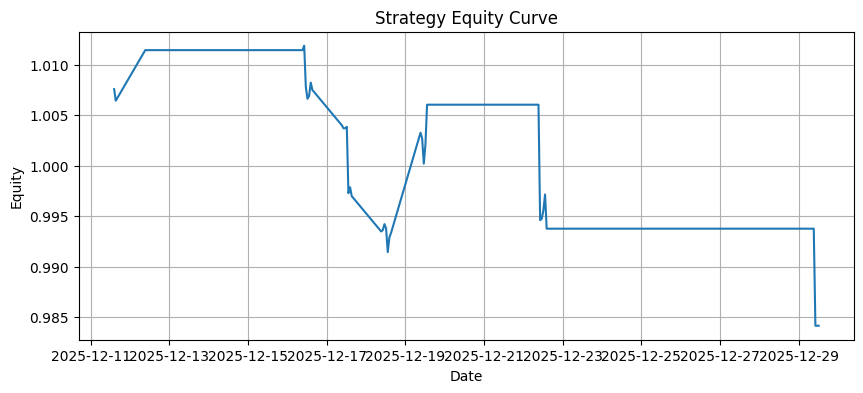

In [27]:
test_df["equity"] = (1 + test_df["strategy_return"]).cumprod()

plt.figure(figsize=(10,4))
plt.plot(test_df["date"], test_df["equity"])
plt.title("Strategy Equity Curve")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid()
plt.show()


In [28]:
def sharpe_ratio(returns):
    return np.sqrt(252) * returns.mean() / returns.std()

def max_drawdown(equity):
    peak = equity.cummax()
    return ((equity - peak) / peak).min()

print("Sharpe Ratio:", sharpe_ratio(test_df["strategy_return"]))
print("Max Drawdown:", max_drawdown(test_df["equity"]))
print("Total Return:", test_df["equity"].iloc[-1] - 1)


Sharpe Ratio: -1.2219735627228032
Max Drawdown: -0.027446148471445858
Total Return: -0.015871174567988255


In [29]:
last_row = df.tail(1)[features]
last_scaled = scaler.transform(last_row)

future_signal = model.predict(last_scaled)[0]

print(
    "Prediction for Next 5 Trading Days:",
    "UP 📈" if future_signal == 1 else "DOWN 📉"
)


Prediction for Next 5 Trading Days: DOWN 📉


In [30]:
def fyers_place_order(signal):
    """
    FYERS API EXECUTION PLACEHOLDER
    Authentication intentionally skipped
    """
    if signal == 1:
        print("FYERS ORDER → BUY SONATA")
    else:
        print("FYERS ORDER → NO TRADE")

fyers_place_order(future_signal)


FYERS ORDER → NO TRADE
